# SVM Ranking Demo
* This demo is a simulation. Imagine a list of N items [1, 2, 3, ... , N] which we know the ground truth ranking for.
* Each item is simply ranked by its index or number.
* Now lets randomly show an SVC a subset of all possible comparisons and let the SVC guess the rankings.
* How good is the generated ranking?

# Generate Data 

In [1]:
import random as rnd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
N   = 200          # Item count
PR  = 5            # Comparisons per item
NOS = 0.1          # Noise ratio
CPP = 3            # Comparison per pair
TOT = N * PR * CPP # Total # of pairs

In [3]:
# Generate all possible unique pairs and then subsample
def gen_pairs():
    # Generate all n * ( n - 1 ) / 2
    poss_pairs = [(x, y) for x in range(N) for \
                             y in range(N) if x < y]

    # Sample N * PR (items * pairs_per_item) from the total
    pairs = rnd.sample(poss_pairs, N * PR) * CPP
    pairs = np.array(pairs)

    return pairs

pairs = gen_pairs()
pairs[:5]

array([[ 47, 119],
       [ 46, 181],
       [ 59, 161],
       [  6, 105],
       [ 69, 199]])

# Convert to One-hot

In [4]:
# One-hot encoding

def one_hot(pairs):
    # Function to one-hot encode pairs:
    # (0, 3) => [1, 0, 0 ,0] - [0, 0, 0, 1] = [1, 0, 0, -1]
    idy = np.identity(N)
    vectorise = lambda x:idy[x[0]] - idy[x[1]]

    # Encode
    X = np.array(list(map(vectorise, pairs)))
    
    return X

X = one_hot(pairs)
X[:5]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

In [5]:
X.shape

(3000, 200)

# Add Noise

In [6]:
def add_noise():
    # Add noise
    y = [1 if (rnd.random() > NOS) else -1 for i in range(TOT)]
    y = np.array(y).reshape(TOT, 1)

    return y

y = add_noise()
y[:20]

array([[ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [-1],
       [ 1]])

In [7]:
y.shape

(3000, 1)

# Balance Class Labels

In [8]:
def balance_class_labels(X, y):
    # Balance class labels by randomly flipping comparison direction
    flip = [1 if (rnd.random() > 0.5) else -1 for i in range(TOT)]
    flip = np.array(flip).reshape(TOT, 1)

    # Flip the pairs
    X = np.multiply(flip, X)
    y = np.multiply(flip, y)
    
    return X, y

X, y = balance_class_labels(X,y)

X[:5]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

# Rank using SVC

In [9]:
from sklearn.svm import LinearSVC

In [10]:
def SVC_rank(X, Y):
    cls = LinearSVC()
    model = cls.fit(X, Y)
    
    res = model.coef_
    ranks = np.flip(np.argsort(res), axis=1)
    
    return ranks

In [11]:
l = SVC_rank(X, y)[0]
l

C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([  5,  44,   0,  11,  31,   4,   1,  19,  45,   8,  20,   7,  16,
         3,  10,  17,  13,  29,  59,  65,  37,   2,  32,  54,  42,  12,
        53,  48,   6,  30,  23,  43,  27,  87,  47,  28,  66,  62,  38,
        73,   9,  15,  18,  81,  58,  51,  88,  74,  57,  41,  39,  82,
        64,  56,  21,  61,  52,  26,  60,  79,  67,  50, 107,  22,  69,
        78,  83,  40,  34,  91,  55,  24, 110,  33, 121, 120, 114,  68,
        49,  71,  89,  93,  95,  14,  86, 100,  90,  84,  72, 108,  25,
        46, 135,  36,  94,  96, 102,  97, 106, 124,  80,  76,  99, 104,
       103, 101, 152, 134, 131, 150,  92,  98, 132,  85, 145,  75,  70,
       113,  63, 118, 123, 129,  77, 128, 112, 115, 105, 176, 119, 140,
       167, 159, 137, 133,  35, 136, 139, 109, 127, 126, 178, 149, 130,
       151, 111, 116, 153, 148, 125, 117, 143, 177, 146, 144, 154, 142,
       199, 138, 165, 141, 166, 157, 156, 160, 147, 164, 122, 155, 194,
       158, 186, 172, 169, 163, 174, 175, 181, 162, 171, 182, 18

# Evaluation

In [12]:
# Now show the rank correlation with assumed ground-truth and the generated ranking.
from scipy.stats import spearmanr
spearmanr(SVC_rank(X, y)[0], range(N))

C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SpearmanrResult(correlation=0.91383484587114683, pvalue=1.9867361933646522e-79)

# How reliable appen data is when comparing ranks

* The graph below shows the probability of a ranking difference generated by SVC being a correct comparison (x axis) relative to the ranking difference (y axis)

In [13]:
all_ress = []

# We change the ratio of pairwise comparisons per item to see the impact
for PR in [20, 15, 10, 5]:
    TOT = N * PR * CPP
    n = 100
    ress = [list() for i in range(n)]

    for k in range(n):
        pairs = gen_pairs()
        y = add_noise()
        X = one_hot(pairs)
        X, y = balance_class_labels(X, y)
        l = SVC_rank(X, y)[0]

        for i in [1] + list(range(5, 101, 5)):
            s = 0
            f = 0
            for j in range(100):
                r1 = rnd.randint(0, len(l) - i - 1)
                r2 = r1 + i

                if l[r1] < l[r2]:
                    s += 1
                else:
                    f += 1

            ress[k].append(s / (s + f))
        
    all_ress.append(ress)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


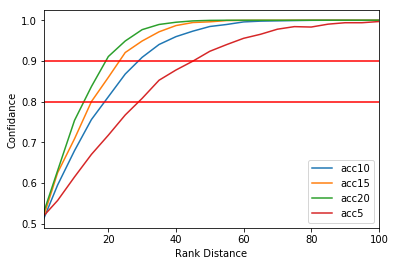

In [14]:
# The more pairwise comparisons we generate, the more accurate is the generated ranking!
totals = [[sum([l[i] for l in all_ress[j]]) / n for i in range(len(all_ress[j][0]))] for j in range(len(all_ress))]

ax = pd.DataFrame({
    'acc5': totals[3],
    'acc10': totals[2],
    'acc15': totals[1],
    'acc20': totals[0],
}, index=[1] + list(range(5, 101, 5))).plot(kind='line')

ax.axhline(0.8, color='r')
ax.axhline(0.9, color='r')
ax.set_xlabel('Rank Distance')
ax.set_ylabel('Confidance')
plt.show()

# Till when can we trust the rankings (Pariwise comparison rankings)

* This depends on the amount of data collected relative to the number of items. The chart below shows the expected rank correlation between a scoring method with:
    * Reality (the absolute true ranking) ORANGE LINE
    * Ground truth (the rankings from pariwise comparisons) BLUE LINE
* This shows how the rank correlation with a noisy ranking does not always reflect reality and we can stop trusting the ranking at some point (0.92 rho in the case below)

In [15]:
corr_w_re = []
corr_w_gt = []

for PR in range(1, 95, 1):
    TOT = N * PR * CPP
    pairs = gen_pairs()
    y = add_noise()
    X = one_hot(pairs)
    X, y = balance_class_labels(X, y)
    temp = SVC_rank(X, y)
    
    corr_w_re.append(spearmanr(temp[0], range(N))[0])
    corr_w_gt.append(spearmanr(temp[0], l)[0])

C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


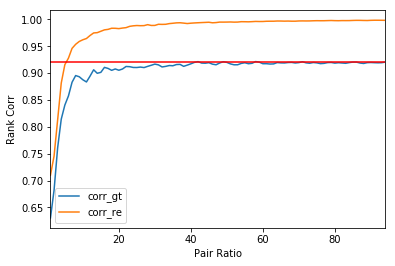

In [18]:
corr_w_gt_s = []
corr_w_re_s = []

for i in range(len(corr_w_gt)):
    lb = max(0, i - 1)
    ub = min(len(corr_w_gt) - 1, i + 1)
    
    corr_w_gt_s.append(np.mean(corr_w_gt[lb:ub]))
    corr_w_re_s.append(np.mean(corr_w_re[lb:ub]))

ax = pd.DataFrame({
    'corr_gt': corr_w_gt_s,
    'corr_re': corr_w_re_s
}, index=range(1, 95, 1)).plot(kind='line')
ax.axhline(0.92, color='r')
ax.set_xlabel('Pair Ratio')
ax.set_ylabel('Rank Corr')
plt.show()


# Motivation
* The applications (Recommender systems and IR).
* System comparison (Can we do statistical significance?).
* The simulation can be improved by better choice of pairs as the comparisons results are being produced.

# Demotivation
* Does not scale well. The are ways to make it scale for larger items and other methods which sacrafice quality for speed.